# Etude de marché pour une entreprise française d'agroalimentaire

**Contexte de l'exercice :**

L'objectif est de proposer une analyse sur des groupements de pays que l'on pourrait cibler pour exporter des poulets.

Des ressources seront à ma disposition ainsi que les données libres d'accès du site de la FAO (https://www.fao.org/faostat/fr/#data/)

La première étape de ce projet sera de sélectionner les données adéquates aux analyse qui suivront.
Dans un second temps, il s'agira de proposer un dendogramme pour visualiser une classification ascendante hérarchique, utiliser la méthode des k-means pour affiner l'analyse et réaliser une ACP pour visualiser les résulats et les comprendre.

### Partie 1 : Sélection et nettoyage des données

In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
from sklearn.decomposition import PCA
from math import exp, sqrt, pi
from scipy.stats import chi2_contingency, pearsonr

In [47]:
# Avec les jeux de données à ma disposition, je décide de ne garder que l'année 2017
# pour avoir les données les plus complètes possibles

dispo_alim = pd.read_csv("DisponibiliteAlimentaire_2017.csv")
population = pd.read_csv("Population_2000_2018.csv")
fao_data = pd.read_csv("FAO_data.csv")

In [48]:
dispo_alim.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [49]:
# Nous allons travailler uniquement sur les données relatives au Produit : Viande de Vollailes

def filter_dispo(df):
    df = df[['Zone', 'Élément', 'Produit', 'Année', 'Unité', 'Valeur']]
    df = df[df['Produit'] == 'Viande de Volailles']
    df = df.drop(columns=['Produit', 'Année'])
    return df


dispo_filtered = filter_dispo(dispo_alim)
dispo_filtered.head(15)

,Zone,Élément,Unité,Valeur
651,Afghanistan,Production,Milliers de tonnes,28.00
652,Afghanistan,Importations - Quantité,Milliers de tonnes,29.00
653,Afghanistan,Variation de stock,Milliers de tonnes,0.00
654,Afghanistan,Disponibilité intérieure,Milliers de tonnes,57.00
655,Afghanistan,Pertes,Milliers de tonnes,2.00
656,Afghanistan,Résidus,Milliers de tonnes,0.00
657,Afghanistan,Nourriture,Milliers de tonnes,55.00
658,Afghanistan,Disponibilité alimentaire en quantité (kg/pers...,kg,1.53
659,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),Kcal/personne/jour,5.00
660,Afghanistan,Disponibilité de protéines en quantité (g/pers...,g/personne/jour,0.54


In [50]:
# Les colonnes sans unité de mesure sont exprimées en milliers de tonnes.

def transform_dispo(df):
    df = df.pivot(index='Zone', columns='Élément', values='Valeur').reset_index()
    df = df.drop(columns=['Alimentation pour touristes', 'Aliments pour animaux', 'Autres utilisations (non alimentaire)', 'Disponibilité de matière grasse en quantité (g/personne/jour)', 'Nourriture', 'Pertes', 'Résidus', 'Semences', 'Traitement', 'Exportations - Quantité'])
    return df

pivot_dispo = transform_dispo(dispo_filtered)
pivot_dispo.head()

Élément,Zone,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Importations - Quantité,Production,Variation de stock
0,Afghanistan,5.0,1.53,0.54,57.0,29.0,28.0,0.0
1,Afrique du Sud,143.0,35.69,14.11,2118.0,514.0,1667.0,-0.0
2,Albanie,85.0,16.36,6.26,47.0,38.0,13.0,4.0
3,Algérie,22.0,6.38,1.97,277.0,2.0,275.0,0.0
4,Allemagne,71.0,19.47,7.96,1739.0,842.0,1514.0,-29.0


In [51]:
# Aperçu du dataframe 'population'

population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [52]:
# Nettoyage des données du dataframe 'population'
# Focus sur la population de chaque pays en 2017 et 
# calcul de l'évolution de la population entre 2000 et 2017

def transform_population(df):
    
    df['Valeur'] = df['Valeur'].astype(int)
    df = df[df['Année'].isin([2000, 2017])]
    df_pivot = df.pivot(index='Zone', columns='Année', values='Valeur').reset_index()
    df_pivot['Evolution Pop % (2000-2017)'] = ((df_pivot[2017] - df_pivot[2000]) / df_pivot[2000]) * 100
    df_pivot = df_pivot[['Zone', 2017, 'Evolution Pop % (2000-2017)']]
    df_pivot = df_pivot.rename(columns={2017: 'Population 2017'})
    df_pivot['Population 2017'] = df_pivot['Population 2017'] * 1000
    df_pivot['Evolution Pop % (2000-2017)'] = round(df_pivot['Evolution Pop % (2000-2017)'])
    
    return df_pivot


pivot_pop = transform_population(population)
pivot_pop.head(15)

Année,Zone,Population 2017,Evolution Pop % (2000-2017)
0,Afghanistan,36296000.0,75.0
1,Afrique du Sud,57009000.0,27.0
2,Albanie,2884000.0,-8.0
3,Algérie,41389000.0,33.0
4,Allemagne,82658000.0,2.0
5,Andorre,77000.0,18.0
6,Angola,29816000.0,82.0
7,Anguilla,14000.0,27.0
8,Antigua-et-Barbuda,95000.0,25.0
9,Antilles néerlandaises (ex),275000.0,28.0


In [53]:
fao_data.head(10)

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,528,Pays-Bas,6121,Valeur,21010,Suffisance des apports énergétiques alimentair...,20162018,2016-2018,%,127.00,E,Valeur estimée,NaN
1,FS,Données de la sécurité alimentaire,528,Pays-Bas,6128,Valeur,22000,Disponibilité alimentaire par habitant utilisé...,20162018,2016-2018,Kcal/personne/jour,3274.00,E,Valeur estimée,NaN
2,FS,Données de la sécurité alimentaire,528,Pays-Bas,6123,Valeur,21013,Disponibilités protéiques moyennes (g/personne...,20162018,2016-2018,g/personne/jour,104.70,E,Valeur estimée,NaN
3,FS,Données de la sécurité alimentaire,528,Pays-Bas,6123,Valeur,21014,Disponibilités protéines moyennes d’origine an...,20162018,2016-2018,g/personne/jour,68.00,E,Valeur estimée,NaN
4,FS,Données de la sécurité alimentaire,528,Pays-Bas,6126,Valeur,22013,"PIB par habitant, ($ PPA internationaux consta...",2017,2017,I$,55088.60,X,Ciffre de sources internationales,NaN
5,FS,Données de la sécurité alimentaire,528,Pays-Bas,6125,Valeur,21032,Stabilité politique et absence de violence/ter...,2017,2017,indice,0.92,X,Ciffre de sources internationales,NaN
6,FS,Données de la sécurité alimentaire,528,Pays-Bas,6127,Valeur,21030,Variabilité de la production alimentaire par h...,2017,2017,1000 I$,30.00,E,Valeur estimée,NaN
7,FS,Données de la sécurité alimentaire,528,Pays-Bas,6128,Valeur,21031,Variabilité des disponibilités alimentaires pa...,2017,2017,Kcal/personne/jour,8.00,E,Valeur estimée,NaN
8,FS,Données de la sécurité alimentaire,4,Afghanistan,6121,Valeur,21010,Suffisance des apports énergétiques alimentair...,20162018,2016-2018,%,106.00,E,Valeur estimée,NaN
9,FS,Données de la sécurité alimentaire,4,Afghanistan,6128,Valeur,22000,Disponibilité alimentaire par habitant utilisé...,20162018,2016-2018,Kcal/personne/jour,2266.00,E,Valeur estimée,NaN


In [54]:
def transform_faodata(df):
    
    df = df.drop(columns=['Code Domaine','Domaine', 'Code zone (M49)','Code Élément','Élément','Code Produit','Code année','Année','Symbole','Description du Symbole','Note','Unité'])
    df_pivot = df.pivot(index='Zone', columns='Produit', values='Valeur').reset_index()
    
    return df_pivot

pivot_fao = transform_faodata(fao_data)
pivot_fao.head()

Produit,Zone,Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans),Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans),Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans),"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice),Suffisance des apports énergétiques alimentaires moyens (%) (moyenne sur 3 ans),Variabilité de la production alimentaire par habitant ($I par personne constant 2014-16),Variabilité des disponibilités alimentaires par habitant (Kcal/personne/jour)
0,Afghanistan,2266.0,10.7,58.0,2058.4,-2.80,106.0,6.8,27.0
1,Afrique du Sud,2902.0,35.7,79.7,13860.3,-0.28,121.0,15.7,21.0
2,Albanie,3314.0,61.0,113.3,12771.0,0.38,133.0,9.2,42.0
3,Algérie,3402.0,25.0,89.3,11737.4,-0.92,149.0,10.3,27.0
4,Allemagne,3551.0,63.0,104.3,53071.5,0.59,140.0,16.4,14.0


In [55]:
# Selection des colonnes les plus importantes en supprimant celles qui ne nous serviront pas

pivot_dispo = pivot_dispo.drop(columns=['Disponibilité alimentaire en quantité (kg/personne/an)', 'Disponibilité intérieure', 'Variation de stock'])
pivot_pop = pivot_pop.drop(columns=['Population 2017'])
pivot_fao = pivot_fao.drop(columns=['Disponibilités protéines moyennes d’origine animale (g/personne/jour) (moyenne sur 3 ans)', 'Disponibilités protéiques moyennes (g/personne/jour) (moyenne sur 3 ans)', 'Suffisance des apports énergétiques alimentaires moyens (%) (moyenne sur 3 ans)', 'Variabilité de la production alimentaire par habitant ($I par personne constant 2014-16)', 'Variabilité des disponibilités alimentaires par habitant (Kcal/personne/jour)'])

In [56]:
pivot_dispo.head()

Élément,Zone,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Importations - Quantité,Production
0,Afghanistan,5.0,0.54,29.0,28.0
1,Afrique du Sud,143.0,14.11,514.0,1667.0
2,Albanie,85.0,6.26,38.0,13.0
3,Algérie,22.0,1.97,2.0,275.0
4,Allemagne,71.0,7.96,842.0,1514.0


In [57]:
pivot_pop.head()

Année,Zone,Evolution Pop % (2000-2017)
0,Afghanistan,75.0
1,Afrique du Sud,27.0
2,Albanie,-8.0
3,Algérie,33.0
4,Allemagne,2.0


In [58]:
pivot_fao.head()

Produit,Zone,Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans),"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice)
0,Afghanistan,2266.0,2058.4,-2.80
1,Afrique du Sud,2902.0,13860.3,-0.28
2,Albanie,3314.0,12771.0,0.38
3,Algérie,3402.0,11737.4,-0.92
4,Allemagne,3551.0,53071.5,0.59


Explication des choix de ces données pour l'étude de marché : 

 - Disponibilité alimentaire (Kcal/personne/jour) (volailles) : Cet indicateur mesure la disponibilité moyenne de calories provenant de la consommation de viande de volaille par personne et par jour dans chaque zone. Il vous permet de comprendre le niveau de consommation actuel de viande de volaille dans les pays cibles et d'évaluer le potentiel de croissance de la demande.

 - Disponibilité de protéines en quantité (g/personne/jour) (volaille) : Cet indicateur mesure la disponibilité moyenne de protéines provenant de la consommation de viande de volaille par personne et par jour dans chaque zone. Il est important car il vous permet d'évaluer la contribution de la viande de volaille à l'apport protéique total de la population cible.

 - Importations - Quantité (volaille) : Cet indicateur vous informe sur le niveau d'importation de viande de volaille dans chaque zone. Il vous permet de comprendre si les pays cibles sont susceptibles d'importer des produits de volaille et d'identifier les opportunités potentielles pour votre entreprise.

 - Production (volaille) : Cet indicateur mesure la production nationale de viande de volaille dans chaque zone. Il est essentiel pour évaluer si les pays cibles ont une production suffisante pour répondre à leur demande intérieure et s'il existe des possibilités d'exportation de votre entreprise vers ces marchés.

 - Evolution Pop % (2000-2017) : Cet indicateur vous donne un aperçu de l'évolution de la population dans les pays cibles au cours des dernières décennies. Il est utile pour anticiper les tendances démographiques et leur impact sur la demande alimentaire, y compris la demande de viande de volaille.

 - Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans) : Cet indicateur est important pour évaluer si la disponibilité alimentaire moyenne est suffisante pour répondre aux besoins nutritionnels de la population. Une disponibilité alimentaire insuffisante peut indiquer des opportunités de croissance pour votre entreprise.

 - PIB par habitant ($ PPA internationaux constants de 2017) : Le PIB par habitant est un indicateur économique qui permet d'évaluer la capacité des consommateurs à acheter des produits alimentaires, y compris la viande de volaille. Un PIB élevé peut indiquer un pouvoir d'achat plus élevé et donc un marché potentiellement lucratif.

 - Stabilité politique et absence de violence/terrorisme (indice) : La stabilité politique est essentielle pour créer un environnement commercial favorable à l'expansion internationale. L'absence de violence et de terrorisme peut contribuer à la confiance des investisseurs et des consommateurs, facilitant ainsi l'entrée sur de nouveaux marchés.

In [59]:
# Fusionner les dataframes en utilisant la colonne "Zone" comme clé de jointure
complete = pd.merge(pivot_dispo, pivot_fao, on='Zone')
complete = pd.merge(complete, pivot_pop, on='Zone')

# Afficher le dataframe résultant
complete.head()

,Zone,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Importations - Quantité,Production,Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans),"PIB par habitant, ($ PPA internationaux constants de 2017)",Stabilité politique et absence de violence/terrorisme (indice),Evolution Pop % (2000-2017)
0,Afghanistan,5.0,0.54,29.0,28.0,2266.0,2058.4,-2.80,75.0
1,Afrique du Sud,143.0,14.11,514.0,1667.0,2902.0,13860.3,-0.28,27.0
2,Albanie,85.0,6.26,38.0,13.0,3314.0,12771.0,0.38,-8.0
3,Algérie,22.0,1.97,2.0,275.0,3402.0,11737.4,-0.92,33.0
4,Allemagne,71.0,7.96,842.0,1514.0,3551.0,53071.5,0.59,2.0


In [60]:
def rename_columns(df, column_mapping):
    return df.rename(columns=column_mapping)

complete = rename_columns(complete, {
    "Disponibilité alimentaire par habitant utilisée dans l'estimation de la prévalence de la sous-alimentation (kcal/personne/jour) (moyenne sur 3 ans)": 'Disponibilité alimentaire totale (Kcal/personne/jour)',
    'PIB par habitant, ($ PPA internationaux constants de 2017)': 'PIB / Habitant ($)',
    'Stabilité politique et absence de violence/terrorisme (indice)': 'Stabilité politique (indice)',
    'Importations - Quantité' : 'Importations volailles (milliers tonnes)',
    'Disponibilité de protéines en quantité (g/personne/jour)': 'Disponibilité de protéines (g/personne/jour)',
    'Production' : 'Production volailles (milliers tonnes)',
    'Disponibilité alimentaire (Kcal/personne/jour)' : 'Disponibilité alimentaire volailles (Kcal/personne/jour)'
})

complete.describe()

,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017)
count,172.000000,172.000000,170.000000,168.000000,158.000000,164.000000,169.000000,169.000000
mean,74.558140,7.121279,89.529412,725.190476,2926.196203,20342.903659,-0.064201,29.366864
std,60.571277,5.603464,186.669983,2501.457125,422.957549,20803.735703,0.900989,28.846190
min,0.000000,0.040000,0.000000,0.000000,1900.000000,912.800000,-2.940000,-19.000000
25%,22.000000,2.165000,3.000000,13.750000,2634.000000,5011.275000,-0.630000,9.000000
50%,64.000000,6.505000,16.000000,70.000000,2897.000000,13265.700000,0.000000,25.000000
75%,105.500000,10.365000,81.250000,409.750000,3288.250000,28880.475000,0.650000,46.000000
max,243.000000,27.870000,1069.000000,21914.000000,3817.000000,126144.000000,1.600000,203.000000


In [61]:
# Dernier nettoyage pour avoir un dataframe complet

print('Valeurs en doublon sur complete : ' + str(complete.duplicated().sum()))
print('\nValeurs manquantes :\n', complete.isna().any())

Valeurs en doublon sur complete : 0

Valeurs manquantes :
 Zone                                                        False
Disponibilité alimentaire volailles (Kcal/personne/jour)    False
Disponibilité de protéines (g/personne/jour)                False
Importations volailles (milliers tonnes)                     True
Production volailles (milliers tonnes)                       True
Disponibilité alimentaire totale (Kcal/personne/jour)        True
PIB / Habitant ($)                                           True
Stabilité politique (indice)                                 True
Evolution Pop % (2000-2017)                                  True
dtype: bool


In [63]:
# Je décide de remplacer les informations manquantes (NaN)
# dans les colonnes Importations, Production , Disponibilité alimentaire totale par la valeur 0
# et je supprime les lignes dont les valeurs PIB, Stabitilité politique et Evolution pop

complete['Importations volailles (milliers tonnes)'].fillna(0, inplace=True)
complete['Production volailles (milliers tonnes)'].fillna(0, inplace=True)
complete['Disponibilité alimentaire totale (Kcal/personne/jour)'].fillna(0, inplace=True)
complete.dropna(inplace=True)

# Je supprime la France car ce pays n'est pas concerné par l'étude de marché
complete.drop(complete[complete['Zone'] == 'France'].index, inplace=True)

print('\nValeurs manquantes :\n', complete.isna().any())
complete.describe()


Valeurs manquantes :
 Zone                                                        False
Disponibilité alimentaire volailles (Kcal/personne/jour)    False
Disponibilité de protéines (g/personne/jour)                False
Importations volailles (milliers tonnes)                    False
Production volailles (milliers tonnes)                      False
Disponibilité alimentaire totale (Kcal/personne/jour)       False
PIB / Habitant ($)                                          False
Stabilité politique (indice)                                False
Evolution Pop % (2000-2017)                                 False
dtype: bool


,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017)
count,160.00000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,74.73750,7.143625,85.250000,626.225000,2675.562500,20317.293125,-0.037375,29.981250
std,61.35734,5.658735,185.951843,2148.761928,919.999171,20936.564110,0.872980,29.271978
min,0.00000,0.040000,0.000000,0.000000,0.000000,912.800000,-2.800000,-19.000000
25%,21.50000,1.970000,3.000000,11.000000,2546.500000,5011.275000,-0.622500,9.000000
50%,64.00000,6.505000,16.000000,64.500000,2873.500000,12936.550000,0.015000,25.000000
75%,105.50000,10.365000,78.250000,345.250000,3258.000000,28880.475000,0.660000,46.750000
max,243.00000,27.870000,1069.000000,21914.000000,3817.000000,126144.000000,1.600000,203.000000


In [64]:
# Nous choisirons de travailler sur 8 variables quantitatives

complete.head()

,Zone,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017)
0,Afghanistan,5.0,0.54,29.0,28.0,2266.0,2058.4,-2.80,75.0
1,Afrique du Sud,143.0,14.11,514.0,1667.0,2902.0,13860.3,-0.28,27.0
2,Albanie,85.0,6.26,38.0,13.0,3314.0,12771.0,0.38,-8.0
3,Algérie,22.0,1.97,2.0,275.0,3402.0,11737.4,-0.92,33.0
4,Allemagne,71.0,7.96,842.0,1514.0,3551.0,53071.5,0.59,2.0


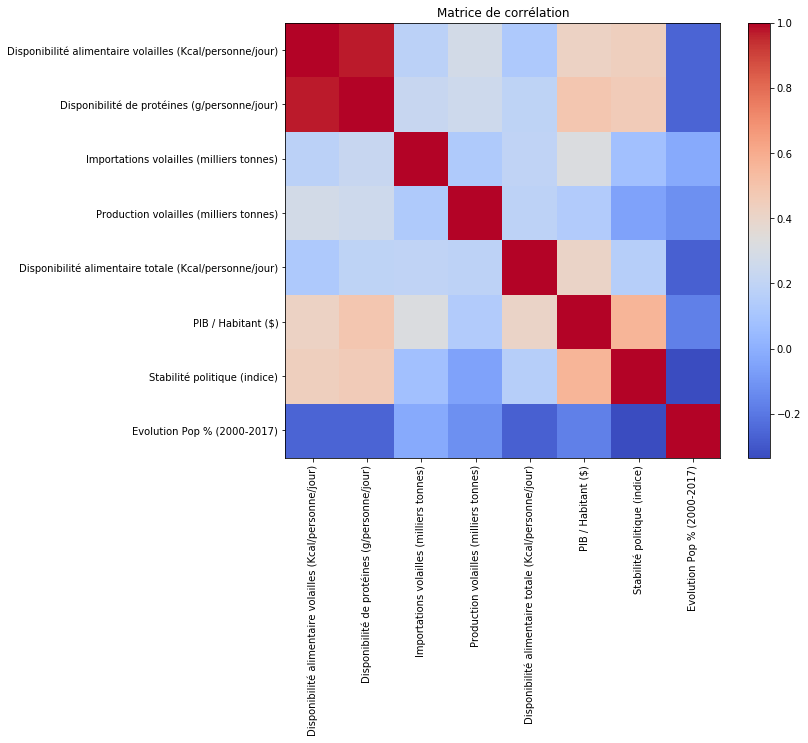

In [65]:
# A l'aide d'une matrice de corrélation, je peux rapidement avoir une représentation visuelle
# des corrélations entre les différentes variables du dataframe 'complete'

df = complete

# Vérifier les corrélations entre les variables
correlation_matrix = df.corr()

# Réaliser une matrice de corrélation visuelle (heatmap)
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Matrice de corrélation')
plt.show()

Quelques observations peuvent être faites : 

Les corrélations positives intéressantes :
 - Il existe une corrélation positive significative entre le PIB / Habitant ou la Stabilité Politique  et la Disponibilité alimentaire volailles ou la Disponibilité de protéines. Cela peut être un bon indicateur pour cibler les marchés potentiels où la demande de volaille pourrait être plus élevée
 
Les corrélations négatives intéressantes : 
 - Une corrélation négative a été observée entre la production de volailles et l'évolution de la population. Cette constatation suggère que la croissance de la population pourrait dépasser l'augmentation de la production de volailles, ce qui pourrait indiquer un potentiel de marché favorable pour l'importation de poulets dans ces pays.

In [67]:
complete.to_csv('complete.csv')